## Pop & Housing variables pulled from 2010, and 2020 Censuses visualized by Census Block

Total Housing Units, Population, Population by Ethncity, Total Occupied Housing Units,  

Note: to update list of comp cities, adjust dictionary in getters script. also note Indianapolis is a consolidated city.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon
import geopandas as gpd

In [2]:
import getters as get

In [34]:
acre = 0.000247105

In [4]:
#import block data
blk_10 = pd.read_csv('../data/geo/blk_vil_10_reduced.csv')
blk_20 = pd.read_csv('../data/geo/blk_vil_20_reduced.csv')
for df in [blk_10,blk_20]: df.geoid = df.geoid.apply(lambda x: '{0:0>15}'.format(x))

drop_cols = ['aland','awater','lat','lon','land_acre']
for df in [blk_10,blk_20]: df.drop(drop_cols,axis=1,inplace=True)
for df in [blk_10,blk_20]: df.rename({'geoid':'GEO_ID'},axis=1,inplace=True)

In [5]:
## set sources, define variable lists by Decennial Census year
#SF1 Dec in 2010, Redistricting file in 2020 (until 2020 tables are released)

source_dec = 'dec/sf1'
source_red = 'dec/pl'

#variables for each Census
years = {'2010':'P001001,P005003,P005004,P005005,P005006,P005007,P005008,P005009,P005010,H003001,H003002,H003003',\
        '2020':'P1_001N,P2_002N,P2_005N,P2_006N,P2_007N,P2_008N,P2_009N,P2_010N,P2_011N,H1_001N,H1_002N,H1_003N'}

#rename 2010 columns to group
col_10_rename={'P001001':'Pop_10E','P005003':'P_Wh_10E','P005004':'P_Bl_10E','P005006':'P_Ot_10E','P005010':'P_Hi_10E',\
               'P005005':'P_Ot_10E','P005007':'P_Ot_10E','P005008':'P_Ot_10E','P005009':'P_Ot_10E',\
              'H003001':'Hou_10E','H003002':'Hou_O_10E','H003003':'Hou_V_10E'}

#rename 2020 columns to group
col_20_rename = {'P1_001N':'Pop_20E','P2_002N':'P_Hi_20E',\
              'P2_005N':'P_Wh_20E','P2_006N':'P_Bl_20E',\
              'P2_007N':'P_Ot_20E','P2_008N':'P_Ot_20E','P2_009N':'P_Ot_20E',\
              'P2_010N':'P_Ot_20E','P2_011N':'P_Ot_20E','H1_001N':'Hou_20E',\
              'H1_002N':'Hou_O_20E','H1_003N':'Hou_V_20E'}

### Urban Village for 2010 and 2020 from blocks

In [17]:
bk10 = get.get_blk(source_dec,list(years.keys())[0],years.get(list(years.keys())[0]),blk_10)
bk20 = get.get_blk(source_red,list(years.keys())[1],years.get(list(years.keys())[1]),blk_20)

for df in [bk10,bk20]:
    for col in df.columns[2:]:
        df[col] = df[col].astype(int)
    
bk10.rename(columns=col_10_rename,inplace=True)
bk20.rename(columns=col_20_rename,inplace=True)

bk10 = bk10.groupby(bk10.columns,axis=1).sum()
bk20 = bk20.groupby(bk20.columns,axis=1).sum()


bk10[f'P_NWh_10E'] = bk10[f'Pop_10E'] - bk10[f'P_Wh_10E']
bk20[f'P_NWh_20E'] = bk20[f'Pop_20E'] - bk20[f'P_Wh_20E']

#bk = pd.merge(bk10,bk20,how='left',on='name')

In [18]:
bk10.head()

,GEO_ID,Hou_10E,Hou_O_10E,Hou_V_10E,P_Bl_10E,P_Hi_10E,P_Ot_10E,P_Wh_10E,Pop_10E,name,P_NWh_10E
0,040136106003004,9,8,1,1,4,2,12,19,North Gateway,7
1,040136100004012,21,21,0,6,7,10,53,76,Rio Vista,23
2,040136100004029,22,19,3,0,11,8,44,63,Rio Vista,19
3,040136100004004,20,16,4,0,3,0,48,51,Rio Vista,3
4,040136100004008,13,12,1,0,8,2,38,48,Rio Vista,10


## Map Housing Units

In [48]:
phx = gpd.read_file('../data/geo/shapefiles/phx.geojson')
villages = gpd.read_file('../data/geo/shapefiles/Villages.shp')
villages = villages.to_crs(4269)

In [7]:
# allow max rows and colums to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [35]:
geo10 = gpd.read_file('../data/geo/shapefiles/blk_10.geojson')
geo10['land_acre'] = geo10['ALAND10'] * acre
g10 = geo10[['GEOID10','Village','geometry','land_acre']].copy()
df10 = pd.merge(g10,bk10,how='left',left_on='GEOID10',right_on='GEO_ID')
df10['hou_den'] = df10['Hou_10E']/df10['land_acre']

In [50]:
geo20 = gpd.read_file('../data/geo/shapefiles/blk_20.geojson')
geo20['land_acre'] = geo20['ALAND20'] * acre
g20 = geo20[['GEOID20','Village','geometry','land_acre']].copy()
df20 = pd.merge(g20,bk20,how='left',left_on='GEOID20',right_on='GEO_ID')
df20['hou_den'] = df20['Hou_20E']/df20['land_acre']

# HOUSING DENSITY

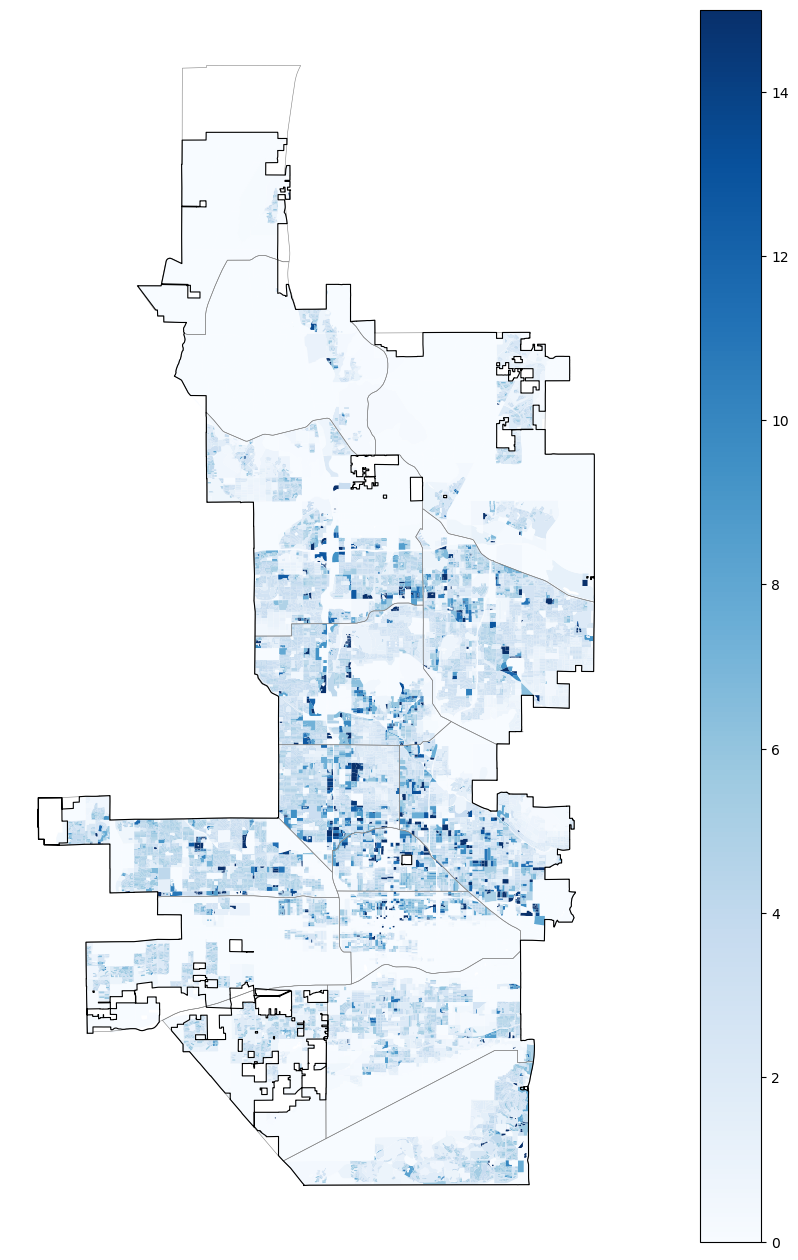

In [52]:
fig, ax = plt.subplots(1, figsize = (20,16))
ax.axis('off')
new_norm = plt.Normalize(vmin=0,vmax=15)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=new_norm)
sm.set_array([])
df10.plot(column = 'hou_den', cmap='Blues', norm=new_norm, edgecolor="white", linewidth=0.0, ax=ax)
villages.plot(ax=ax,color='none',edgecolor='gray',linewidth=0.4)
phx.plot(ax=ax,color='none',edgecolor='black',linewidth=0.8)
fig.colorbar(sm)

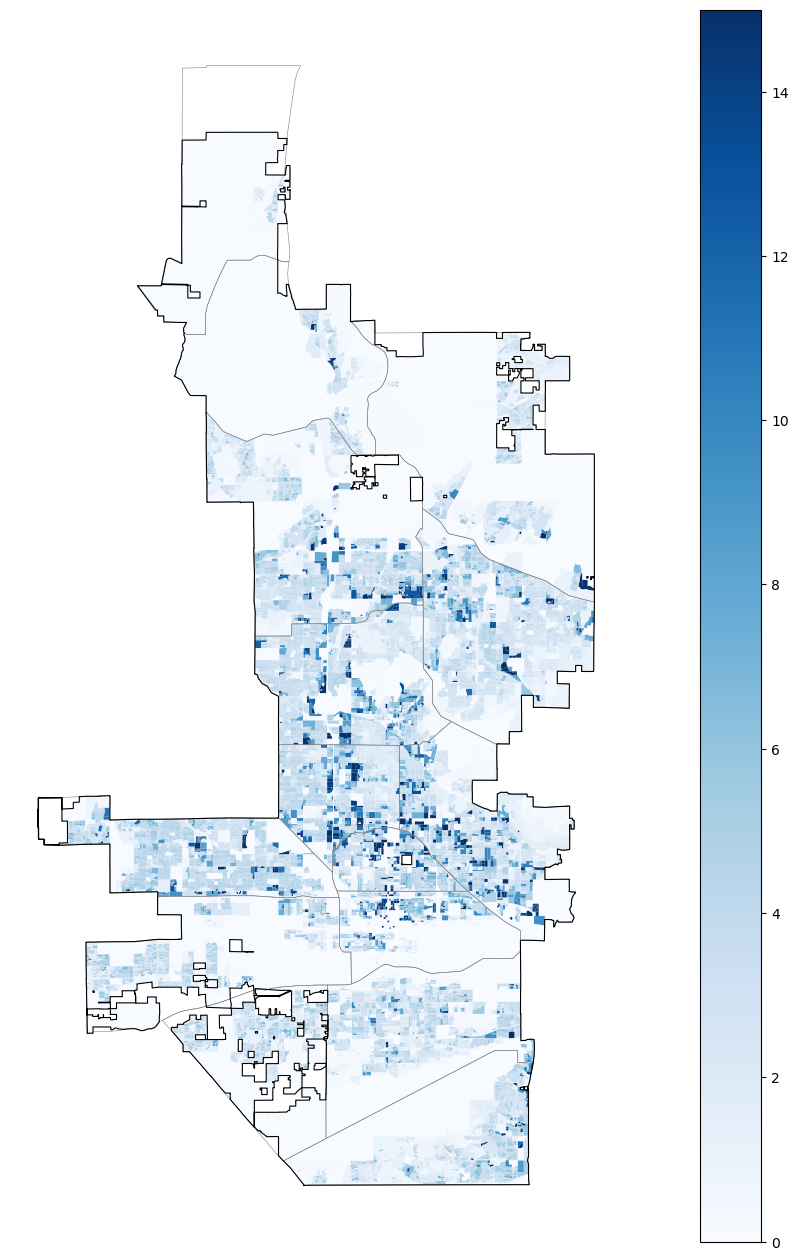

In [53]:
fig, ax = plt.subplots(1, figsize = (20,16))
ax.axis('off')
new_norm = plt.Normalize(vmin=0,vmax=15)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=new_norm)
sm.set_array([])
df20.plot(column = 'hou_den', cmap='Blues', norm=new_norm, edgecolor="white", linewidth=0.0, ax=ax)
villages.plot(ax=ax,color='none',edgecolor='gray',linewidth=0.4)
phx.plot(ax=ax,color='none',edgecolor='black',linewidth=0.8)
fig.colorbar(sm)